 # Models and Ensembling Methods + Interpretability with LIME

 ## Import dependencies

In [1]:
import numpy
from gensim.models import word2vec
from gensim.models import KeyedVectors
import pandas
from nltk import WordPunctTokenizer
from sklearn.preprocessing import label_binarize
import sqlite3
from sklearn.multiclass import OneVsRestClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_learning_curves
import lime
import lime.lime_tabular
import lime.lime_text


 ## Define Constants

In [2]:
W2V_FEATURE_SIZE = 300
N_CLASSES = 4
RANDOM_STATE = 123
N_FOLDS = 5


 ## Read in the data

 ### Load raw train and test data

 #### Load in the data from the database

In [3]:
dbconn = sqlite3.connect('./data/cleanedtraintest_v2.db')
train_data_df = pandas.read_sql_query(
    'SELECT category, content_cleaned FROM train_data', dbconn)
test_data_df = pandas.read_sql_query(
    'SELECT category, content_cleaned FROM test_data', dbconn)
dbconn.commit()
dbconn.close()


 #### Check the if the data was loaded correctly

In [4]:
train_data_df


,category,content_cleaned
0,3,wall street seeing green
1,3,private investment firm carlyle group reputati...
2,3,soaring crude prices plus economy outlook earn...
3,3,authorities halted oil main pipeline southern ...
4,3,tearaway world oil prices toppling records str...
...,...,...
119995,1,pakistani president pervez musharraf said stay...
119996,2,red sox general manager theo epstein acknowled...
119997,2,miami dolphins put courtship lsu coach nick sa...
119998,2,pittsburgh ny giants time line steelers record...


In [5]:
test_data_df


,category,content_cleaned
0,3,unions representing workers turner newall say ...
1,4,toronto canada rocketeers competing million an...
2,4,company founded chemistry researcher universit...
3,4,barely dawn mike fitzpatrick starts shift blur...
4,4,southern california agency went emissions bovi...
...,...,...
7595,1,ukrainian presidential candidate viktor yushch...
7596,2,supply attractive pitching options dwindling d...
7597,2,like roger clemens almost exactly eight years ...
7598,3,singapore doctors united states warned painkil...


 #### Train & Test data where x is the predictor features, y is the predicted feature

In [6]:
x_train = train_data_df.content_cleaned
y_train = label_binarize(train_data_df.category, classes=range(1, N_CLASSES + 1))

x_test = test_data_df.content_cleaned
y_test = label_binarize(test_data_df.category, classes=range(1, N_CLASSES + 1))


 ### Load word2vec data

 #### Load word2vec feature arrays from .npz files
 load dict of arrays

In [7]:
w2v_train_features_array_dict = numpy.load(
    './data/word2vec-train-features-120000-min5dim300.npz')
w2v_test_features_array_dict = numpy.load(
    './data/word2vec-test-features-120000-min5dim300.npz')
# extract the first array from train
data = w2v_train_features_array_dict['arr_0']
# print the array
print(data)
# extract the first array from test
data = w2v_test_features_array_dict['arr_0']
# print the array
print(data)


[[-0.43092448  0.50092196  0.08331972 ...  1.3914201   1.2953259
  -1.8574607 ]
 [-0.10783155 -0.35169265  0.90062636 ... -0.38979718  0.13664657
   0.5066641 ]
 [-1.0086536  -0.29255652 -0.7550053  ... -0.18521406  0.7896786
  -0.23576818]
 ...
 [-0.02566049  0.23409443 -0.8595321  ... -0.05427613 -0.89297265
  -0.09055152]
 [-0.6081659   0.42683512 -0.9105423  ... -0.06156884 -0.40654626
   0.07195716]
 [-1.0819023  -0.04211196 -0.16453283 ... -0.40625843 -0.13644677
  -0.0066904 ]]
[[-0.02657197 -1.0014614  -0.035705   ...  0.48677683  0.3947945
  -0.9894788 ]
 [-0.54866743 -1.3801866   0.66031504 ... -0.4012159   0.6803215
   0.92033225]
 [ 0.11171789  0.3781767  -0.26057357 ... -0.5006595   0.13674003
   0.10530389]
 ...
 [-0.46190766  0.7501185  -0.20256642 ... -0.32613838  0.09363924
   0.46578252]
 [-0.023529   -0.33200815 -0.63418424 ... -0.46149412  0.39634904
  -0.46027517]
 [-0.25388533 -0.6177681   0.9628809  ... -0.66557425 -0.1068292
  -0.64577085]]


 #### Load word2vec model trained key vectors

In [8]:
w2v_model_train = KeyedVectors.load(
    './data/custom-trained-word2vec-120000-min5dim300.kv')


 #### Get the word2vec data back into usable form

In [9]:
wpt = WordPunctTokenizer()
tokenized_corpus_train = [wpt.tokenize(document) for document in x_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in x_test]

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = numpy.zeros((num_features,), dtype="float32")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = numpy.add(feature_vector, model[word])

    if nwords:
        feature_vector = numpy.divide(feature_vector, nwords)

    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
            for tokenized_sentence in corpus]
    return numpy.array(features)


 #### Obtain document level embeddings

In [10]:
w2v_feature_array_train = averaged_word_vectorizer(corpus=tokenized_corpus_train,
    model=w2v_model_train, num_features=W2V_FEATURE_SIZE)
w2v_feature_array_test = averaged_word_vectorizer(corpus=tokenized_corpus_test,
    model=w2v_model_train, num_features=W2V_FEATURE_SIZE)

x_train_w2v = pandas.DataFrame(w2v_feature_array_train)
x_test_w2v = pandas.DataFrame(w2v_feature_array_test)


 #### Sample down for speed, for now. (use when testing)
 x_train_w2v = x_train_w2v.sample(
     n = 3000, replace = False, random_state = RANDOM_STATE
 )
 y_train = train_data_df.category.sample(
     n = 3000, replace = False, random_state = RANDOM_STATE
 )
 y_train = label_binarize(y_train, classes=range(1, N_CLASSES + 1))

 ## Build Models
 ### SVM Model Building Function

In [11]:
def run_svm(x_train, y_train):
    classifier = OneVsRestClassifier(svm.LinearSVC(random_state=RANDOM_STATE))
    classifier.fit(x_train, y_train)
    return classifier


 ### Logistic Regression Model Building Function

In [12]:
def run_logreg(x_train, y_train):
    classifier = OneVsRestClassifier(LogisticRegression(random_state=RANDOM_STATE))
    classifier.fit(x_train, y_train)
    return classifier


 ### Naive Bayes Function

In [13]:
def run_nb(x_train, y_train):
    classifier = OneVsRestClassifier(GaussianNB())
    classifier.fit(x_train, y_train)
    return classifier


 ### Decision Trees Function

In [14]:
def run_dectree(x_train, y_train):
    classifier = OneVsRestClassifier(tree.DecisionTreeClassifier())
    classifier.fit(x_train, y_train)
    return classifier 


 ### Functions to calculate scores and to plot them
 Calculate, then plot the Precision, Recall, Average Precision, F1

In [15]:
def prf1_calc(classifier, algo_name, n_classes, x_test, y_test):
    # Get the decision function from the classifier
    if algo_name == 'SVM':
        y_score = classifier.decision_function(x_test)
    else:
        y_score = classifier.predict_proba(x_test)
    y_pred = classifier.predict(x_test)

    # The average precision score in multi-label settings
    # For each class
    precision = dict()
    recall = dict()
    average_f1 = dict()
    average_precision = dict()
    mcc = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        average_f1[i] = f1_score(y_test[:, i], y_pred[:, i])
        mcc[i] = matthews_corrcoef(y_test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,
                                                        average="micro")
    average_f1['micro'] = f1_score(y_test, y_pred, average='micro')
    mcc['micro'] = sum(mcc.values())/4

    # Plot the data
    prf1_plot(precision, recall, average_precision, algo_name, n_classes)

    # Return all metrics
    results = pandas.DataFrame()

    for k in average_precision.keys():
        results.at[algo_name, f'P-R {k}'] = numpy.round(average_precision[k], 3)
        results.at[algo_name, f'F1 {k}'] = numpy.round(average_f1[k], 3)
        results.at[algo_name, f'MCC {k}'] = numpy.round(mcc[k], 3)

    return results

# Function to Plot Precision, Recall, F1
def prf1_plot(precision, recall, average_precision, algo_name, n_classes):
    print(algo_name)
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))

    # Plot the micro-averaged Precision-Recall curve
    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))
    
    # Plot Precision-Recall curve for each class and iso-f1 curves
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(7, 8))
    f_scores = numpy.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = numpy.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(lines, labels, loc=(0, -.5), prop=dict(size=14))

    plt.show()


 ## Run the Base Models

 ### Run SVM Model

In [16]:
svm_model = run_svm(x_train_w2v, y_train)


 ### Run Logistic Regression Model

In [17]:
logreg_model = run_logreg(x_train_w2v, y_train)


 ### Run Naive Bayes Classifier

In [18]:
nb_model = run_nb(x_train_w2v, y_train)


 ### Run Decision Trees Classifier

In [19]:
dectree_model = run_dectree(x_train_w2v, y_train)


 ## Get the scores

 ### Initialize the dataframe to keep track of the scores

In [20]:
scores = pandas.DataFrame()


 ### Precision, Recall, Avg. Precision for SVM

SVM
Average precision score, micro-averaged over all classes: 0.92


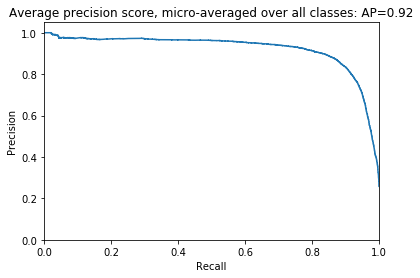

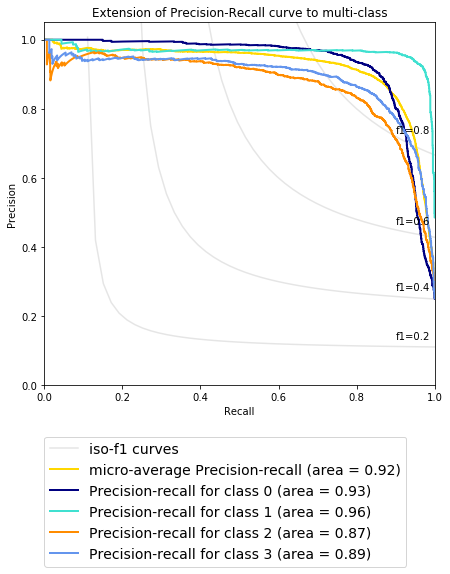

In [21]:
scores = scores.append(prf1_calc(svm_model, 'SVM', N_CLASSES, x_test_w2v, y_test))


 ### Precision, Recall, Avg. Precision for LOG REG

LOGREG
Average precision score, micro-averaged over all classes: 0.92


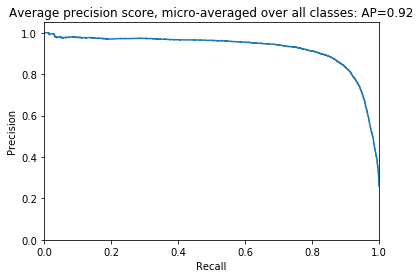

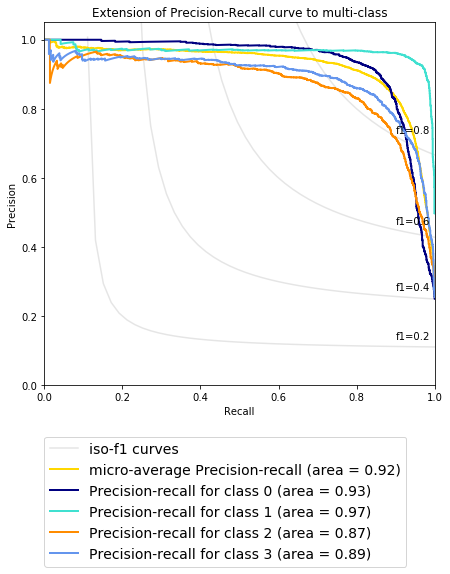

In [22]:
scores = scores.append(prf1_calc(logreg_model, 'LOGREG', N_CLASSES, x_test_w2v, y_test))


 ### Precision, Recall, Avg. Precision for Naive Bayes

NB
Average precision score, micro-averaged over all classes: 0.86


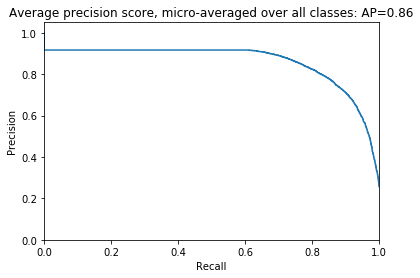

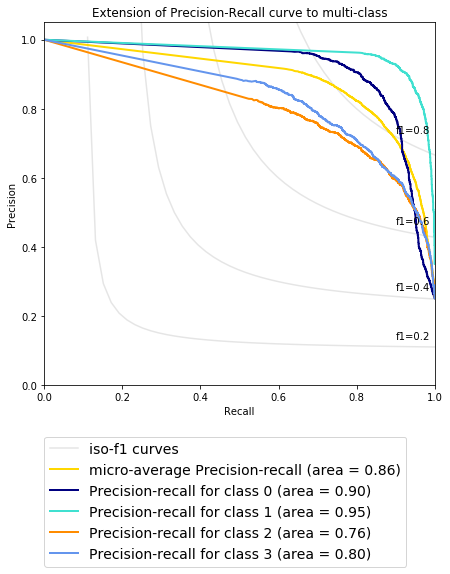

In [23]:
scores = scores.append(prf1_calc(nb_model, 'NB', N_CLASSES, x_test_w2v, y_test))


 ### Precision, Recall, Avg. Precision for Decision Trees

DT
Average precision score, micro-averaged over all classes: 0.63


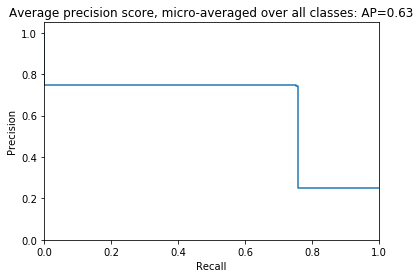

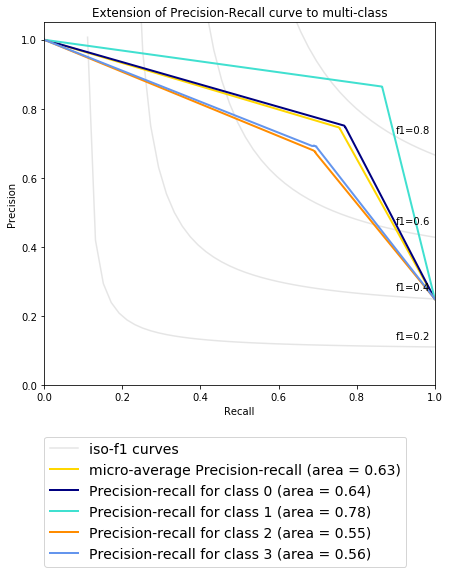

In [24]:
scores = scores.append(prf1_calc(dectree_model, 'DT', N_CLASSES, x_test_w2v, y_test))


 ## Look at Cross-Validation

 ### Create model list to iterate through for cross validation

In [25]:
gnb = OneVsRestClassifier(GaussianNB())
sv = OneVsRestClassifier(svm.LinearSVC(random_state=RANDOM_STATE))
lreg = OneVsRestClassifier(LogisticRegression(random_state=RANDOM_STATE))
dtree = OneVsRestClassifier(tree.DecisionTreeClassifier())

model_list = [gnb, sv, lreg, dtree]
model_namelist = ['Gaussian Naive Bayes',
                  'SVM/Linear SVC', 
                  'Logistic Regression', 
                  'Decision Tree']


 ### Make scoring metrics to pass cv function through

In [26]:
scoring = {'precision': make_scorer(precision_score, average='micro'), 
           'recall': make_scorer(recall_score, average='micro'), 
           'f1': make_scorer(f1_score, average='micro'),
           'roc_auc': make_scorer(roc_auc_score, average='micro'),
           # 'mcc': make_scorer(matthews_corrcoef) <- cannot support multi-label
          }

cv_result_entries = []
i = 0


 ### Loop cross validation through various models and generate results

In [27]:
for mod in model_list:
    metrics = cross_validate(
        mod,
        x_train_w2v,
        y_train,
        cv=N_FOLDS,
        scoring = scoring,
        return_train_score=False,
        n_jobs=-1
    )
    for key in metrics.keys():
        for fold_index, score in enumerate(metrics[key]):
            cv_result_entries.append((model_namelist[i], fold_index, key, score))
    i += 1


 ### Save the cv results to a dataframe

In [28]:
cv_results_df = pandas.DataFrame(cv_result_entries)
cv_results_df.columns = ['algo', 'cv fold', 'metric', 'value']


 ### Plot cv results

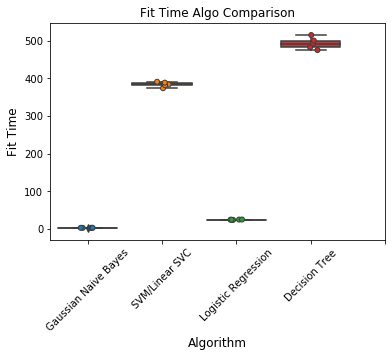

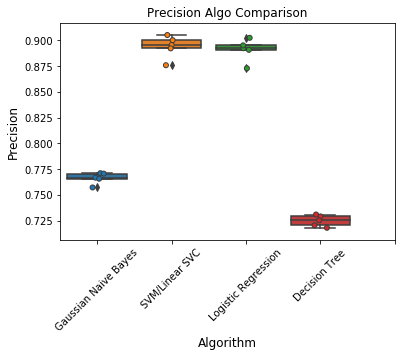

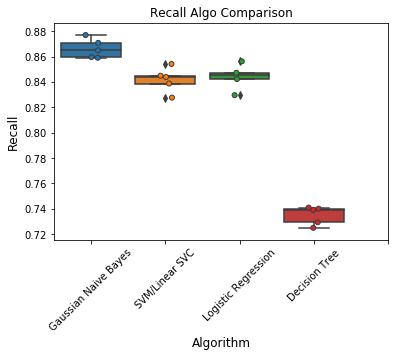

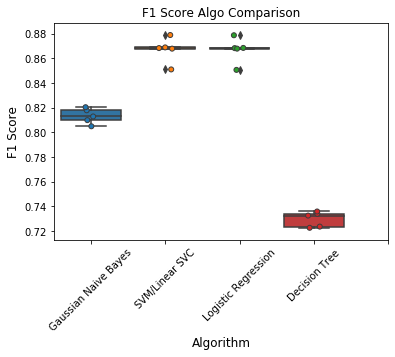

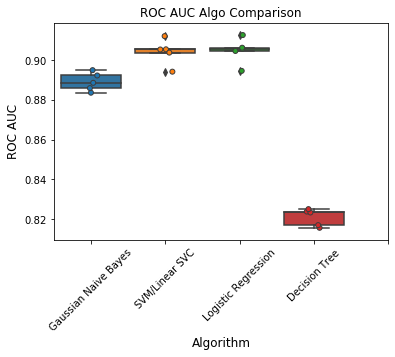

In [29]:
for metric_name, metric in zip(['fit_time',
                                'test_precision',
                                'test_recall',
                                'test_f1',
                                'test_roc_auc'],
                                ['Fit Time',
                                'Precision',
                                'Recall',
                                'F1 Score',
                                'ROC AUC']):
    sns.boxplot(x='algo', y='value', #hue='algo',
        data=cv_results_df[cv_results_df.metric.eq(f'{metric_name}')])
    sns.stripplot(x='algo', y = 'value', 
        data = cv_results_df[cv_results_df.metric.eq(f'{metric_name}')],
        size = 5, linewidth = 1)
    plt.title(f'{metric} Algo Comparison', fontsize=12)
    plt.xlabel('Algorithm', fontsize=12)
    plt.ylabel(f'{metric}', fontsize=12)
    plt.xticks([0, 1, 2, 3, 4])
    plt.xticks(rotation=45)
    plt.show()


 ### Misclassification Errors

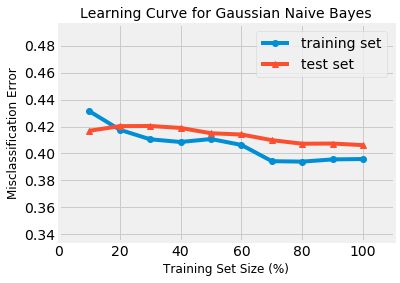

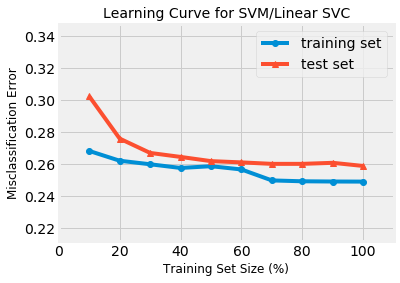

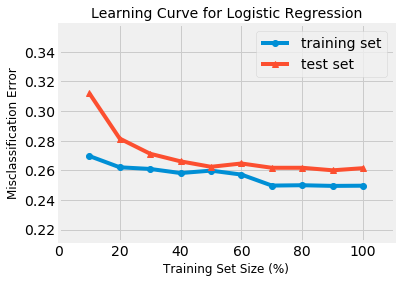

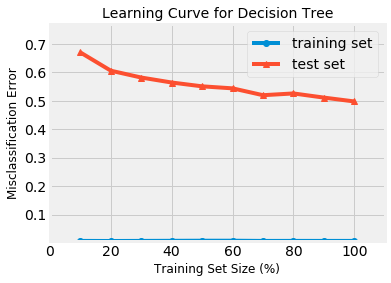

In [30]:
i=0
for model in model_list:
    plt.figure()
    plot_learning_curves(x_train_w2v, y_train, x_test_w2v, y_test, model)
    plt.title('Learning Curve for ' + model_namelist[i], fontsize=14)
    plt.xlabel('Training Set Size (%)', fontsize=12)
    plt.ylabel('Misclassification Error', fontsize=12)
    plt.show()
    i += 1


 ### Get predictions

In [31]:
y_test_pred = []
for model in model_list:
    y_test_pred.append(model.predict(x_test_w2v))


 ### Confusion Matrix

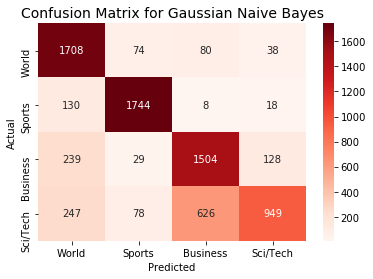

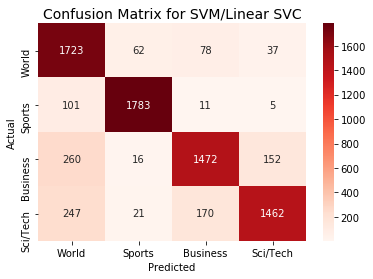

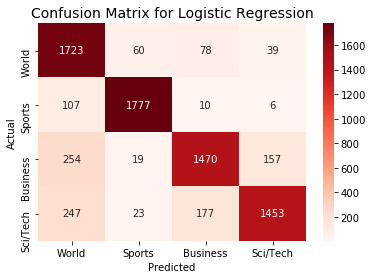

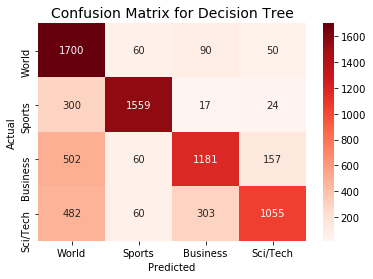

In [32]:
CLASSES = ['World', 'Sports', 'Business', 'Sci/Tech']
i=0
for _ in model_list:
    cm = confusion_matrix(numpy.argmax(y_test, axis=1),
                          numpy.argmax(y_test_pred[i], axis=1))
    cm_df = pandas.DataFrame(cm, index = CLASSES, columns = CLASSES)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    plt.title('Confusion Matrix for ' + model_namelist[i], fontsize=14)
    sns.heatmap(cm_df, annot=True, fmt='.6g', annot_kws={"size": 10}, cmap='Reds')
    plt.show()
    i += 1


 ## HYPER PARAMETER TUNING BY HYPEROPT (not working!!!)
 from hyperopt import STATUS_OK
 N_FOLDS = 5
 Objective Function
 def objective(params, n_folds = N_FOLDS):
     cv_results = cross_validate(OneVsRestClassifier(GaussianNB()),
         x_train_w2v,
         y_train,
         cv = n_folds,
         fit_params= params,
         scoring = {'f1': make_scorer(f1_score, average='micro')},
         return_train_score=False,
         n_jobs=-1
     )
     # Extract the best score
     best_score = max(cv_results['test_f1'])
     # Loss must be minimized
     loss = 1 - best_score
     # Dictionary with information for evaluation
     return {'loss': loss, 'params': params, 'status': STATUS_OK}
 Domain Space
 from hyperopt import hp
 space = {'estimator__var_smoothing': hp.uniform('estimator__var_smoothing',
                           1.e+00, 1.e-09)}
 Optimization Algorithm
 from hyperopt import tpe
 tpe_algo = tpe.suggest
 Results History
 from hyperopt import Trials
 bayes_trials = Trials()
 Run the optimization
 from hyperopt import fmin
 from hyperopt import rand
 MAX_EVALS = 500
 params = space
 Optimize
 best = fmin(fn = objective, space = space, algo = tpe.suggest,
             max_evals = 100, trials = bayes_trials)
 print(best)

In [33]:
tempx = x_train_w2v
tempy = y_train
x_train_w2v = x_train_w2v.sample(n = 3000, replace = False, random_state = RANDOM_STATE)
y_train = train_data_df.category.sample(
    n = 3000, replace = False, random_state = RANDOM_STATE
)
y_train = label_binarize(y_train, classes=range(1, N_CLASSES + 1))

 ## Hyper-parameter tuning with exhaustive Grid Search
 ### Tune hyperparameters for Gaussian Naive-Bayes

In [34]:
params_gnb = {'estimator__var_smoothing': [1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
                                           1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]
}
clf = GridSearchCV(estimator=gnb,
                   param_grid=params_gnb,
                   scoring='f1_micro',
                   n_jobs=-1,
                   cv=N_FOLDS,
                   return_train_score=True
                  )
clf_res = clf.fit(x_train_w2v, y_train)
print('Best Score: ', clf_res.best_score_)
print('Best Params: ', clf_res.best_params_)


Best Score:  0.801674851179991
Best Params:  {'estimator__var_smoothing': 0.001}


 ### Tune hyperparameters for Logistic Regression

In [35]:
params_lreg = {
    "estimator__penalty": ['l1', 'l2'],
    "estimator__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    #"estimator__class_weight":[{1:0.5, 0:0.5}, {1:0.4, 0:0.6},
    #                           {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
    "estimator__solver": ["newton-cg", "sag", "saga", "lbfgs"]
}
clf = GridSearchCV(estimator=lreg,
                   param_grid=params_lreg,
                   scoring='f1_micro',
                   n_jobs=-1,
                   cv=N_FOLDS,
                   return_train_score=True
                  )
clf_res = clf.fit(x_train_w2v, y_train)
print('Best score:', clf_res.best_score_)
print('Best Params:', clf_res.best_params_)


Best score: 0.8320745341017949
Best Params: {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'newton-cg'}


 ### Tune hyperparameters for SVM (Linear SVC)

In [36]:
params_sv = {
    "estimator__penalty":['l1', 'l2'],
    "estimator__tol": [1.e-08, 1.e-07, 1.e-06, 1.e-05,
                       1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
    "estimator__loss":['hinge','squared_hinge'],
    "estimator__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    #"estimator__class_weight":['None',{1:0.5, 0:0.5}, 
    #                           {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
}
clf = GridSearchCV(estimator=sv,
                   param_grid=params_sv,
                   scoring='f1_micro',
                   n_jobs=-1,
                   cv=N_FOLDS,
                   return_train_score=False
                  )
clf_res = clf.fit(x_train_w2v, y_train)
print('Best score:', clf_res.best_score_)
print('Best Params:', clf_res.best_params_)


Best score: 0.8440514791910111
Best Params: {'estimator__C': 0.001, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'estimator__tol': 1e-08}


 ### Tune hyperparameters for Decision Trees

In [37]:
params_dtree = {
    "estimator__splitter":["best", "random"],
    "estimator__min_samples_split":range(1, 20, 1)
}
clf = GridSearchCV(estimator=dtree,
                   param_grid=params_dtree,
                   scoring='f1_micro',
                   n_jobs=-1,
                   cv=N_FOLDS,
                   return_train_score=False
                  )
clf_res = clf.fit(x_train_w2v, y_train)
print('Best score:', clf_res.best_score_)
print('Best Params:', clf_res.best_params_)


Best score: 0.6739645310596253
Best Params: {'estimator__min_samples_split': 2, 'estimator__splitter': 'best'}


 ### Conclusion:
 Apparently the best params are pretty much the default ones.
 The algorithms are already pretty smart about the defaults or can calculate them.
 This tuning these hyper-parameters might actually cause overfitting.

 ## Ensemble Methods

 ### Stacking

In [38]:
estimators = [
              ('nb', GaussianNB()),
              ('svm', svm.LinearSVC())
             ]

sclf = OneVsRestClassifier(StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())
)

metrics = cross_validate(
    sclf,
    x_train_w2v,
    y_train,
    cv=N_FOLDS,
    scoring = scoring,
    return_train_score=False,
    n_jobs=-1
)

res = []
for key in metrics.keys():
    for fold_index, score in enumerate(metrics[key]):
        res.append(('Stacking', fold_index, key, score))

res_df = pandas.DataFrame.from_dict(res)
res_df.columns = ['algo', 'cv fold', 'metric', 'value']
cv_results_inc_ens = pandas.concat([cv_results_df, res_df])
print(res_df)


        algo  cv fold          metric      value
0   Stacking        0        fit_time  15.978150
1   Stacking        1        fit_time  13.521015
2   Stacking        2        fit_time  14.955231
3   Stacking        3        fit_time  15.738349
4   Stacking        4        fit_time  14.079458
5   Stacking        0      score_time   0.033269
6   Stacking        1      score_time   0.043593
7   Stacking        2      score_time   0.034031
8   Stacking        3      score_time   0.037050
9   Stacking        4      score_time   0.039699
10  Stacking        0  test_precision   0.844884
11  Stacking        1  test_precision   0.814941
12  Stacking        2  test_precision   0.812709
13  Stacking        3  test_precision   0.828431
14  Stacking        4  test_precision   0.768139
15  Stacking        0     test_recall   0.853333
16  Stacking        1     test_recall   0.800000
17  Stacking        2     test_recall   0.810000
18  Stacking        3     test_recall   0.845000
19  Stacking        

 ### Bagging

In [39]:
sclf = OneVsRestClassifier(BaggingClassifier(
    base_estimator=LogisticRegression())
)

metrics = cross_validate(
    sclf,
    x_train_w2v,
    y_train,
    cv=N_FOLDS,
    scoring = scoring,
    return_train_score=False,
    n_jobs=-1
)

res = []
for key in metrics.keys():
    for fold_index, score in enumerate(metrics[key]):
        res.append(('Bagging', fold_index, key, score))

res_df = pandas.DataFrame.from_dict(res)
res_df.columns = ['algo', 'cv fold', 'metric', 'value']
cv_results_inc_ens = pandas.concat([cv_results_inc_ens, res_df])
print(res_df)


       algo  cv fold          metric     value
0   Bagging        0        fit_time  7.736371
1   Bagging        1        fit_time  6.614771
2   Bagging        2        fit_time  7.947237
3   Bagging        3        fit_time  7.898628
4   Bagging        4        fit_time  7.793030
5   Bagging        0      score_time  0.069687
6   Bagging        1      score_time  0.087241
7   Bagging        2      score_time  0.052184
8   Bagging        3      score_time  0.049625
9   Bagging        4      score_time  0.066190
10  Bagging        0  test_precision  0.847341
11  Bagging        1  test_precision  0.811189
12  Bagging        2  test_precision  0.837012
13  Bagging        3  test_precision  0.836522
14  Bagging        4  test_precision  0.808219
15  Bagging        0     test_recall  0.823333
16  Bagging        1     test_recall  0.773333
17  Bagging        2     test_recall  0.821667
18  Bagging        3     test_recall  0.801667
19  Bagging        4     test_recall  0.786667
20  Bagging  

 ### Boosting

In [40]:
from sklearn.ensemble import AdaBoostClassifier
sclf = OneVsRestClassifier(AdaBoostClassifier(
    random_state=RANDOM_STATE)
)

metrics = cross_validate(
    sclf,
    x_train_w2v,
    y_train,
    cv=N_FOLDS,
    scoring = scoring,
    return_train_score=False,
    n_jobs=-1
)

res = []
for key in metrics.keys():
    for fold_index, score in enumerate(metrics[key]):
        res.append(('AdaBoost', fold_index, key, score))

res_df = pandas.DataFrame.from_dict(res)
res_df.columns = ['algo', 'cv fold', 'metric', 'value']
cv_results_inc_ens = pandas.concat([cv_results_inc_ens, res_df])
print(res_df)


        algo  cv fold          metric      value
0   AdaBoost        0        fit_time  17.320381
1   AdaBoost        1        fit_time  17.439707
2   AdaBoost        2        fit_time  17.461761
3   AdaBoost        3        fit_time  17.493534
4   AdaBoost        4        fit_time  17.432340
5   AdaBoost        0      score_time   0.086413
6   AdaBoost        1      score_time   0.081883
7   AdaBoost        2      score_time   0.080395
8   AdaBoost        3      score_time   0.082230
9   AdaBoost        4      score_time   0.079237
10  AdaBoost        0  test_precision   0.818653
11  AdaBoost        1  test_precision   0.805054
12  AdaBoost        2  test_precision   0.805508
13  AdaBoost        3  test_precision   0.818018
14  AdaBoost        4  test_precision   0.790738
15  AdaBoost        0     test_recall   0.790000
16  AdaBoost        1     test_recall   0.743333
17  AdaBoost        2     test_recall   0.780000
18  AdaBoost        3     test_recall   0.756667
19  AdaBoost        

 ### Plot cv results

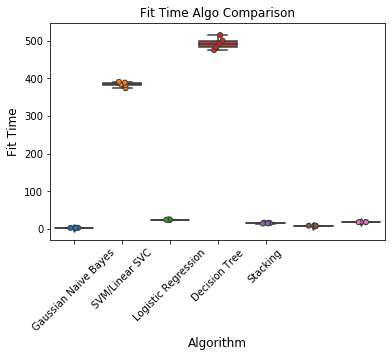

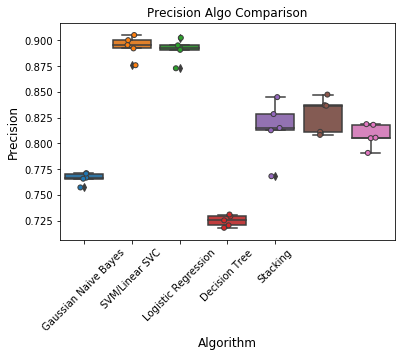

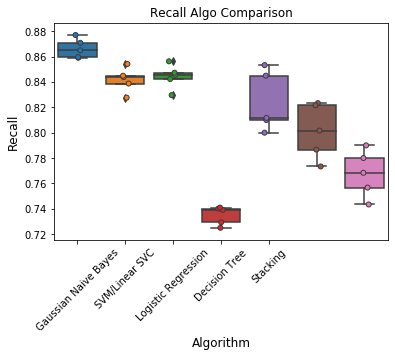

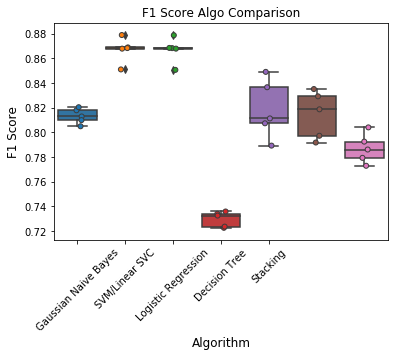

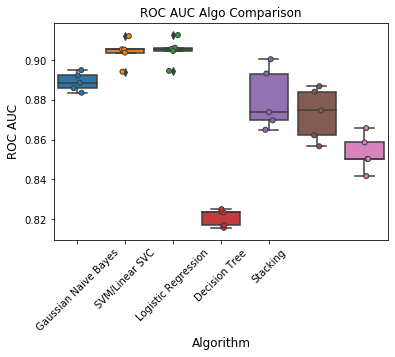

In [41]:
for metric_name, metric in zip(['fit_time',
                                'test_precision',
                                'test_recall',
                                'test_f1',
                                'test_roc_auc'],
                                ['Fit Time',
                                'Precision',
                                'Recall',
                                'F1 Score',
                                'ROC AUC']):
    sns.boxplot(x='algo', y='value', #hue='algo',
        data=cv_results_inc_ens[cv_results_inc_ens.metric.eq(f'{metric_name}')])
    sns.stripplot(x='algo', y = 'value', 
        data = cv_results_inc_ens[cv_results_inc_ens.metric.eq(f'{metric_name}')],
        size = 5, linewidth = 1)
    plt.title(f'{metric} Algo Comparison', fontsize=12)
    plt.xlabel('Algorithm', fontsize=12)
    plt.ylabel(f'{metric}', fontsize=12)
    plt.xticks([0, 1, 2, 3, 4])
    plt.xticks(rotation=45)
    plt.show()


 ## Save our results

In [42]:
cv_results_inc_ens.to_csv('./data/cv-results-inc-ens.csv')


 ## LIME for model interpretation

In [43]:
class_names=['World','Sports','Business','Tech/Sci']


 #### Instantiate explainer

In [44]:
tab_explainer = lime.lime_tabular.LimeTabularExplainer(x_train_w2v.values,
    mode='classification', class_names=class_names)


 #### Get explanations for: idx = Document #

In [45]:
idx = 34
tab_exp_lreg = tab_explainer.explain_instance(x_test_w2v.values[idx], lreg.predict_proba,
    num_features=10, top_labels=1)
print('Document id: %d' % idx)
print('Predicted class =',
    class_names[numpy.argmax(lreg.predict(numpy.array(x_test_w2v.values[idx]).reshape(1, -1)))])
print('True class =', class_names[numpy.argmax(y_test[idx])])


Document id: 34
Predicted class = World
True class = World


 #### Get a text-only explanation

In [46]:
print ('\n'.join(map(str, tab_exp_lreg.as_list(label=numpy.argmax(y_test[idx])))))


('113 <= -0.08', 0.043060045089148416)
('35 <= -0.38', 0.041094166403712974)
('226 > 0.26', 0.041073713579853226)
('170 > 0.35', -0.04073013084985671)
('100 <= -0.51', 0.03946447383035468)
('70 > 0.38', 0.03761791602673489)
('186 > 0.28', 0.035300291693019875)
('227 > 0.25', 0.03457857730526656)
('68 > 0.42', -0.03231149309595331)
('199 > 0.36', 0.03126601004514614)


 #### Get a graphical explanation of the predicted class

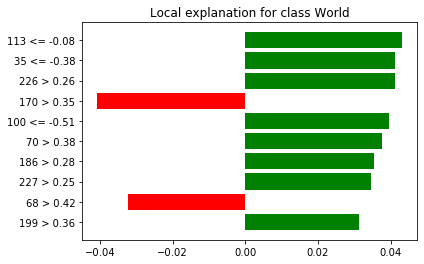

In [47]:
fig = tab_exp_lreg.as_pyplot_figure(label=numpy.argmax(y_test[idx]))


 #### Get a graphical explanation with class probabilities

In [48]:
tab_exp_lreg.show_in_notebook()


 ## References - Code sample sources disclaimer:
 Code for this project is either directly from (with some modification),
 or inspired by, but not limited to the following sources:
 - Respective documentation and examples from each used API's doc/guide website
 - Kelly Epley Naive Bayes:
   https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e
 - MLWhiz's excellent blogs about text classification and NLP:
   https://mlwhiz.com/blog/2018/12/17/text_classification/
   https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/
   https://mlwhiz.com/blog/2019/02/08/deeplearning_nlp_conventional_methods/
   https://www.kaggle.com/mlwhiz/conventional-methods-for-quora-classification/
 - Christof Henkel preprocessing:
   https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
 - datanizing GmbH:
   https://medium.com/@datanizing/modern-text-mining-with-python-part-1-of-5-introduction-cleaning-and-linguistics-647f9ec85b6a
 - Datacamp wordcloud:
   https://www.datacamp.com/community/tutorials/wordcloud-python
 - Seaborn Pydata tutorials:
   https://seaborn.pydata.org/introduction.html#intro-plot-customization
 - Dipanjan S's tutorials:
   https://github.com/dipanjanS
 - Analytics Vidhya:
   https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
 - Jason Brownlee's Feature Selection For Machine Learning in Python
   https://machinelearningmastery.com/feature-selection-machine-learning-python/
 - Susan Li's Multi-class text classification with Scikit-learn:
   https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
 - Vadim Smolyakov Ensemble Learning to Improve Machine Learning Results:
   https://blog.statsbot.co/ensemble-learning-d1dcd548e936
 - Udacity course video on Youtube UD120:
   https://www.youtube.com/watch?v=GdsLRKjjKLw
 - Hyperparameter Tuning with Hyperopt
   https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a
 - Hyperparameter Tuning for Gaussian NB
   https://www.quora.com/Can-the-prior-in-a-naive-Bayes-be-considered-a-hyperparameter-and-tuned-for-better-accuracy
 - Hyperparameter Tuning for Decision Trees
   https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
 - Lime tutorial
   https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html